In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import random
from typing import Dict, List, Tuple, Optional

def load_movielens_data(base_path: str) -> Tuple[Dict, Dict, Dict]:
    df_users = pd.read_csv(f'{base_path}/u.user', sep='|', encoding='latin-1',
                          names=['user_id', 'age', 'gender', 'occupation', 'zipcode'])
    df_users['stt'] = df_users['user_id']
    
    df_movies = pd.read_csv(f'{base_path}/u.item', sep='|', encoding='latin-1',
                           names=['movie_id', 'title', 'release_date', 'video_release_date', 
                                 'IMDb_URL'] + [f'genre_{i}' for i in range(19)])
    df_movies['stt'] = df_movies['movie_id']
    
    df_ratings = pd.read_csv(f'{base_path}/u.data', sep='\t', encoding='latin-1',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    
    users = df_users.set_index('stt').to_dict(orient='index')
    movies = df_movies.set_index('stt').to_dict(orient='index')
    ratings = {(row['user_id'], row['movie_id']): row['rating'] 
              for _, row in df_ratings.iterrows()}
    
    return users, movies, ratings

users, movies, ratings = load_movielens_data('ml-100k')
print(f"Số lượng users: {len(users)}")
print(f"Số lượng movies: {len(movies)}")
print(f"Số lượng ratings: {len(ratings)}")


Số lượng users: 943
Số lượng movies: 1682
Số lượng ratings: 100000


In [18]:
class MovieRecommenderEnv:
    def __init__(self, users: Dict, movies: Dict, ratings: Dict, 
                 possible_ratings: List[int] = [1, 2, 3, 4, 5]):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.possible_ratings = possible_ratings
        self.state: Optional[Tuple[int, int]] = None
        self.user_history = self._build_user_history()
        self.predictions: List[int] = []
        self.actual_ratings: List[int] = []

    def _build_user_history(self) -> Dict[int, List[int]]:
        user_history = {user: [] for user in self.users.keys()}
        for (user, movie), _ in self.ratings.items():
            user_history[user].append(movie)
        return user_history

    def reset(self) -> Tuple[int, int]:
        self.state = self._get_random_state()
        return self.state

    def _get_random_state(self) -> Tuple[int, int]:
        user = random.choice(list(self.users.keys()))
        user_movies = self.user_history.get(user, [])
        movie = random.choice(user_movies) if user_movies else random.choice(list(self.movies.keys()))
        return (user, movie)

    def step(self, action: int) -> Tuple[Tuple[int, int], float]:
        if not self.state:
            raise ValueError("Environment chưa được khởi tạo. Gọi reset() trước.")
            
        user, movie = self.state
        true_rating = self.ratings.get((user, movie), 
                                      random.choice(self.possible_ratings))
        
        reward = self._calculate_reward(true_rating, action)
        
        self.predictions.append(action)
        self.actual_ratings.append(true_rating)
        
        self.state = self._get_random_state()
        
        return self.state, reward

    def _calculate_reward(self, true_rating: int, predicted_rating: int) -> float:
        error = abs(true_rating - predicted_rating)
        if error == 0:
            return 10
        elif error == 1:
            return 5
        elif error == 2:
            return -2
        else:
            return -10

    def evaluate(self) -> float:
        if not self.predictions:
            return float('inf')
        return np.sqrt(mean_squared_error(self.actual_ratings, self.predictions))


In [19]:
class QValueTable(dict):
    def __init__(self, default_value: float = 0.0):
        super().__init__()
        self.visit_counts: Dict[Tuple, int] = {}
        self.default_value = default_value

    def __getitem__(self, key: Tuple) -> float:
        if key in self:
            return super().__getitem__(key) / self.visit_counts[key]
        return self.default_value

    def update(self, key: Tuple, value: float or List[float]) -> None:
        if key not in self:
            super().__setitem__(key, 0.0)
            self.visit_counts[key] = 0

        if isinstance(value, list):
            super().__setitem__(key, super().__getitem__(key) + sum(value))
            self.visit_counts[key] += len(value)
        else:
            super().__setitem__(key, super().__getitem__(key) + value)
            self.visit_counts[key] += 1


In [20]:
class MonteCarloRecommender:
    def __init__(self, env: MovieRecommenderEnv, epsilon: float = 0.1, 
                 max_steps: int = 50, default_q: float = 0.0):
        self.env = env
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.q_table = QValueTable(default_q)

    def recommend(self, episodes: int = 1000, verbose: bool = True) -> Tuple[List[int], float]:
        for episode in range(episodes):
            trajectory = []
            self.env.reset()
            total_score = 0

            for _ in range(self.max_steps):
                state = self.env.state
                action = self._select_action(state)
                next_state, reward = self.env.step(action)
                trajectory.append((state, action, reward))
                total_score += reward

            self._update_q_values(trajectory)

            if verbose and episode % 1000 == 0:
                rmse = self.env.evaluate()
                print(f'Episode {episode}, RMSE: {rmse:.4f}')

        return [step[1] for step in trajectory], total_score

    def _select_action(self, state: Tuple[int, int]) -> int:
        if random.random() < self.epsilon:
            return random.choice(self.env.possible_ratings)

        q_values = [(action, self.q_table[state, action]) 
                   for action in self.env.possible_ratings]
        
        max_q = max(q_values, key=lambda x: x[1])[1]
        best_actions = [a for a, q in q_values if q == max_q]
        
        return random.choice(best_actions)

    def _update_q_values(self, trajectory: List[Tuple]) -> None:
        returns = {}
        for t, (state, action, reward) in enumerate(trajectory):
            if (state, action) not in returns:
                returns[state, action] = []
            
            g_t = sum(step[2] for step in trajectory[t:])
            returns[state, action].append(g_t)

        for key, values in returns.items():
            self.q_table.update(key, values)

    def get_policy_statistics(self) -> Dict:
        stats = {
            'total_state_actions': len(self.q_table),
            'avg_q_value': 0.0,
            'max_q_value': float('-inf'),
            'min_q_value': float('inf'),
            'most_common_rating': None
        }
        
        if not self.q_table:
            return stats
            
        q_values = [self.q_table[k] for k in self.q_table]
        stats['avg_q_value'] = np.mean(q_values)
        stats['max_q_value'] = np.max(q_values)
        stats['min_q_value'] = np.min(q_values)
        
        # Tìm rating được đề xuất nhiều nhất
        ratings = [action for state, action in self.q_table.keys()]
        if ratings:
            stats['most_common_rating'] = max(set(ratings), key=ratings.count)
            
        return stats

    def predict(self) -> List[int]:
        predictions = []
        for state in self.env.get_all_states():
            action = self._select_action(state)
            predictions.append(action)
        return predictions


In [21]:
def evaluate_recommender(env, recommender, num_test_episodes=100):
    total_reward = 0
    
    # Reset environment cho evaluation
    env.predictions = []
    env.actual_ratings = []
    
    for _ in range(num_test_episodes):
        state = env.reset()
        for _ in range(recommender.max_steps):
            action = recommender._select_action(state)
            state, reward = env.step(action)
            total_reward += reward
            
    rmse = env.evaluate()
    stats = recommender.get_policy_statistics()
    
    return {
        'rmse': rmse,
        'total_reward': total_reward,
        'avg_reward': total_reward / (num_test_episodes * recommender.max_steps),
        'policy_stats': stats
    }

In [22]:
env = MovieRecommenderEnv(users, movies, ratings)
recommender = MonteCarloRecommender(
    env,
    epsilon=0.4,
    max_steps=50,
    default_q=0
)

print("Bắt đầu training...")
recommendations, total_score = recommender.recommend(episodes=500000)
print("\nĐánh giá mô hình...")
eval_results = evaluate_recommender(env, recommender)

print(f"\nKết quả đánh giá:")
print(f"rmse: {eval_results['rmse']:.4f}")
print(f"Total Reward: {eval_results['total_reward']}")
print(f"Average Reward per Step: {eval_results['avg_reward']:.4f}")
print("\nThống kê về chính sách:")
for key, value in eval_results['policy_stats'].items():
    print(f"{key}: {value}")


Bắt đầu training...
Episode 0, RMSE: 1.9235
Episode 1000, RMSE: 1.8781
Episode 2000, RMSE: 1.8636
Episode 3000, RMSE: 1.8527
Episode 4000, RMSE: 1.8439
Episode 5000, RMSE: 1.8372
Episode 6000, RMSE: 1.8288
Episode 7000, RMSE: 1.8215
Episode 8000, RMSE: 1.8160
Episode 9000, RMSE: 1.8103
Episode 10000, RMSE: 1.8049
Episode 11000, RMSE: 1.7999
Episode 12000, RMSE: 1.7958
Episode 13000, RMSE: 1.7914
Episode 14000, RMSE: 1.7876
Episode 15000, RMSE: 1.7837
Episode 16000, RMSE: 1.7797
Episode 17000, RMSE: 1.7761
Episode 18000, RMSE: 1.7725
Episode 19000, RMSE: 1.7694
Episode 20000, RMSE: 1.7656
Episode 21000, RMSE: 1.7626
Episode 22000, RMSE: 1.7599
Episode 23000, RMSE: 1.7573
Episode 24000, RMSE: 1.7545
Episode 25000, RMSE: 1.7519
Episode 26000, RMSE: 1.7492
Episode 27000, RMSE: 1.7468
Episode 28000, RMSE: 1.7445
Episode 29000, RMSE: 1.7419
Episode 30000, RMSE: 1.7397
Episode 31000, RMSE: 1.7375
Episode 32000, RMSE: 1.7352
Episode 33000, RMSE: 1.7329
Episode 34000, RMSE: 1.7306
Episode 35000

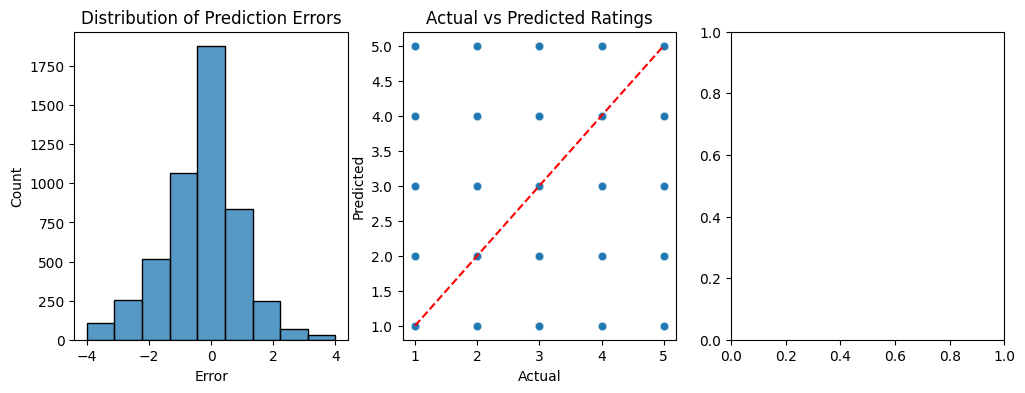

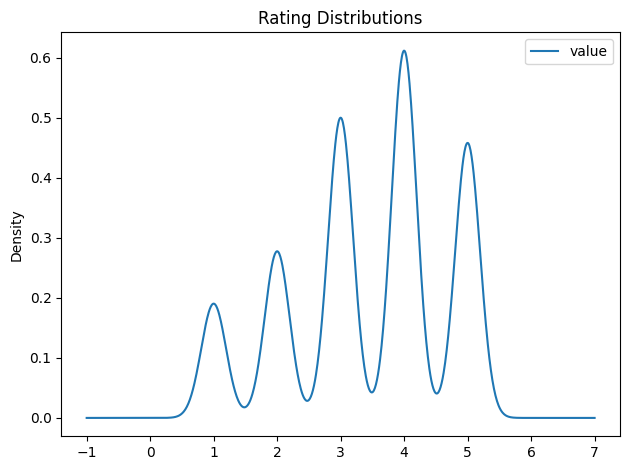


Thống kê chi tiết:
         Predicted       Actual        Error
count  5000.000000  5000.000000  5000.000000
mean      3.264600     3.589000    -0.324400
std       1.314889     1.128332     1.375188
min       1.000000     1.000000    -4.000000
25%       2.000000     3.000000    -1.000000
50%       3.000000     4.000000     0.000000
75%       4.000000     4.000000     0.000000
max       5.000000     5.000000     4.000000

Confusion Matrix:
Predicted    1    2     3     4     5   All
Actual                                     
1          124   78    48    25    28   303
2           93  207   109    55    44   508
3          162  260   460   263   145  1290
4          148  203   396   603   389  1739
5          104  106   151   317   482  1160
All        631  854  1164  1263  1088  5000

Khuyến nghị cho User 1:
1. Sabrina (1995) (Predicted: 5.00)
2. Sense and Sensibility (1995) (Predicted: 5.00)
3. Bed of Roses (1996) (Predicted: 5.00)
4. Up Close and Personal (1996) (Predicted: 5.00)
5.

In [23]:

import matplotlib.pyplot as plt
import seaborn as sns

def analyze_results(env, recommendations):
    results_df = pd.DataFrame({
        'Predicted': env.predictions,
        'Actual': env.actual_ratings,
        'Error': np.array(env.predictions) - np.array(env.actual_ratings)
    })
    
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    sns.histplot(data=results_df, x='Error', bins=9)
    plt.title('Distribution of Prediction Errors')
    
    plt.subplot(132)
    sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.5)
    plt.plot([1, 5], [1, 5], 'r--')
    plt.title('Actual vs Predicted Ratings')
    
    plt.subplot(133)
    results_df[['Actual', 'Predicted']].melt().plot(kind='kde')
    plt.title('Rating Distributions')
    
    plt.tight_layout()
    plt.show()
    
    print("\nThống kê chi tiết:")
    print(results_df.describe())
    
    rounded_pred = np.round(results_df['Predicted'])
    conf_matrix = pd.crosstab(results_df['Actual'], rounded_pred, margins=True)
    print("\nConfusion Matrix:")
    print(conf_matrix)

analyze_results(env, recommendations)

def get_recommendations_for_user(recommender, user_id, n_recommendations=500):
    watched_movies = set(recommender.env.user_history[user_id])
    all_movies = set(recommender.env.movies.keys())
    unwatched_movies = list(all_movies - watched_movies)
    
    predictions = []
    for movie_id in unwatched_movies:
        state = (user_id, movie_id)
        predicted_rating = recommender._select_action(state)
        predictions.append((movie_id, predicted_rating))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_movies = predictions[:n_recommendations]
    
    recommendations = []
    for movie_id, rating in top_movies:
        movie_info = recommender.env.movies[movie_id]
        recommendations.append({
            'movie_id': movie_id,
            'title': movie_info['title'],
            'predicted_rating': rating
        })
    
    return recommendations

test_users = [1, 50, 100]
for user_id in test_users:
    print(f"\nKhuyến nghị cho User {user_id}:")
    recommendations = get_recommendations_for_user(recommender, user_id)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['title']} (Predicted: {rec['predicted_rating']:.2f})")